**This script is to find the optimal threshold from the trading result of different deep learning model (GRU and ESN).**

## Standard Import


In [ ]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR="/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Data"
LABEL_DIR = os.path.join(DATA_DIR,'Label')
DL_DIR =  "/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning"
BT_DIR = os.path.join(DATA_DIR,'Backtesting_TradingStrategy')


Mounted at /content/drive


## Import MLFramework & Backtesting

In [ ]:
%run '/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/MLFramework.ipynb' import MLFramework

In [ ]:
%run '/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Backtesting.ipynb' import backtesting, backtesting_df

     |████████████████████████████████| 175 kB 33.9 MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173822 sha256=778be3396a0731aa6b27dc308d1197eb2d0f3e56ca6d1e315ccc1bcaf1fa792a
  Stored in directory: /root/.cache/pip/wheels/48/1d/ea/65dacebc37da7655d8a1fd0f315ac39d102e31d6545237a1c6
Successfully built backtesting


/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Mounted at /content/drive


# TensorFlow

In [ ]:
# pip install keras-tuner --upgrade
# import keras_tuner as kt

In [ ]:
# pip install tensorflow --upgrade

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa


     |████████████████████████████████| 1.1 MB 18.7 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import SimpleRNN , Dense , LSTM , Dropout, Normalization, Flatten, GRU, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import metrics
from tensorflow_addons.layers import ESN

In [ ]:
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Version 2, minor 8


In [ ]:
def generateTSdata(X,y, look_back):
    
    X_ts =  np.array([X[i:(i+look_back),:] for i in range(X.shape[0]-look_back+1)])
    y_ts = np.array(y[(look_back-1):,:])
    return X_ts, y_ts

In [ ]:
def plotTrain( history, model_name:str, metrics_name:list):
    n = len(metrics_name)+1
    i = math.ceil(n/2)
    j = 2
    fig, axs = plt.subplots( i,j, figsize=(12, 5) )

    # Plot loss
    axs[0,0].plot(history.history['loss'])
    axs[0,0].plot(history.history['val_loss'])
    axs[0,0].set_title(model_name + " " + 'model loss')
    axs[0,0].set_ylabel('loss')
    axs[0,0].set_xlabel('epoch')
    axs[0,0].legend(['train', 'validation'], loc='upper left')
   
    # Plot accuracy
    for k in range(len(metrics_name)):
      i = math.floor((k+1)/2)
      j = (k+1)%2
      acc_string = metrics_name[k]
      axs[i,j].plot(history.history[ acc_string ])
      axs[i,j].plot(history.history['val_' + acc_string ])
      axs[i,j].set_title(model_name + " " +'model '+acc_string)
      axs[i,j].set_ylabel(acc_string)
      axs[i,j].set_xlabel('epoch')
      axs[i,j].legend(['train', 'validation'], loc='upper left')

    return fig, axs

In [ ]:
def showResult(model, X_val_ts,y_val_ts):
    score = model.evaluate(X_val_ts,y_val_ts)
    y_pred = model.predict(X_val_ts)
    print(confusion_matrix(y_val_ts.argmax(axis=1),y_pred.argmax(axis=1)) ) 
    print('Validation Score: ',score)
    print('Validation Prediction: \n',y_pred)
    return

In [ ]:
def standardization(X_train,X_val,X_test):
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)
  X_test = scaler.transform(X_test)
  return X_train, X_val, X_test , scaler


In [ ]:
def overSampling(X_train_Val, y_train_val, jittering=False, numFeatures_colList = [1,2,3], variance = 0.1):
  ### input training dataset or validation dataset; 
  ### y has to be a 3-columns 2-d matrix (n,3)   
  ### X is a 3-d matrix (n, sequence, features)

  Nclass = y_train_val.shape[1]
  Xy_class = []
  ids_class=[]
  print('Before Resmapling:')
  print('X.Shape ',X_train_Val.shape)
  print('y.Shape ',y_train_val.shape)
  for i in range(Nclass):
    ids_class.append( y_train_val[:,i] == 1)
    Xy_class.append((X_train_Val[ids_class[i],:,:], y_train_val[ids_class[i],:]) )
    print(i,Xy_class[i][0].shape)

  print('After Resmapling:')
  n_class = [ind.sum() for ind in ids_class]
  max_n = max(n_class)
  # res_Xy_class =[]
  for i in range(Nclass):
    if n_class[i]!=max_n:
      ids = np.arange(len(Xy_class[i][0] ))
      choices = np.random.choice(ids, max_n- n_class[i])
      X = Xy_class[i][0]
      y = Xy_class[i][1]
      dup_X = X[choices,:,:]
      dup_y = y[choices,:]
      if jittering:
        dup_X[:,:,numFeatures_colList] + np.random.normal(0, variance, ( max_n- n_class[i], X.shape[1], len(numFeatures_colList) ))
      
      res_X = np.concatenate((X,dup_X),axis=0)
      res_y = np.concatenate((y,dup_y),axis=0)
      Xy_class[i] =  ( res_X , res_y)
    print(i,Xy_class[i][0].shape)

  res_X = np.concatenate([Xy_class[i][0] for i in range(Nclass)],axis=0)
  res_y = np.concatenate([Xy_class[i][1] for i in range(Nclass)],axis=0)
  print('X.Shape after resampling',res_X.shape)
  print('y.Shape after resampling',res_y.shape)

  return res_X, res_y



In [ ]:
def pred_threshold(y_pred, threshold):
  return np.array([p.argmax() if (p>threshold).any() else 1 for p in y_pred])-1

In [ ]:
model = {}
history = {}

## Master Control

In [ ]:
labelList = ['POS_RET','hmm2_MA10_shifted','hmm1_EWMA10_shifted','hmm1_shifted']
targetLabel_List = ['POS_RET','hmm2_MA10','hmm1_EWMA10','hmm1']
allHMM = True
look_back = 180
fileName = 'master_ds_v6.csv'

## Read Data

In [ ]:
df_dir = os.path.join(LABEL_DIR,fileName)
df = pd.read_csv(df_dir, parse_dates=True, index_col=0)
df

,PX_LAST,PX_VOLUME,SPXT_Close,SPXT_Volume,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,Mkt-RF,SMB,HML,RF,...,month_8,month_9,month_10,month_11,month_12,PX_Ret,SPXT_Ret,VIX_Close_Diff,Mkt-RF_Diff,SMB_Diff,HML_Diff,RF_Diff,T1M_Diff,T3M_Diff,T6M_Diff,T1Y_Diff,T3Y_Diff,T5Y_Diff,T10Y_Diff,T30Y_Diff,T10Y3M_Diff,T10Y2Y_Diff,LIBOR_3M_Diff,TEDRATE_Diff,InterestRate_Diff,PX_EMA5,PX_EMA10,PX_EMA5_BB_hband,PX_EMA5_BB_lband,PX_EMA5_BB_pband,PX_KAMA10,PX_EMA5_RSI,PX_EMA5_MACD,PX_EMA5_MACD_Diff,PX_EMA5_MACD_Sig,PX_EMA5_VPT,PX_EMA5_FI,PX_EMA5_KST,PX_EMA5_KST_Diff,PX_EMA5_KST_Sig
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-02,585.41,0,386.16,0,NaN,7.83,7.50,7.81,7.90,7.87,7.94,8.00,0.11,0.07,8.38000,0.80,8.54,22.89,0.0490,22.89,0.0490,158.6294,-0.8405,69.0585,190.157,17.2194,2.3009,0.3,0,5.4,0,276,0,17.240000,0.8,0,1.44,-0.68,-0.07,0.026,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,585.05,0,385.17,0,NaN,7.89,7.53,7.85,7.96,7.92,7.99,8.04,0.10,0.05,8.38000,0.75,8.37,23.68,0.0345,23.68,0.0345,166.5505,-6.7745,68.4778,190.767,18.4101,3.0652,0.3,0,5.4,0,276,0,18.190001,0.8,0,-0.06,0.74,-0.26,0.026,...,0,0,0,0,0,-0.000615,-0.002567,0.950001,-1.50,1.42,-0.19,0.0,NaN,0.06,0.03,0.04,0.06,0.05,0.05,0.04,-0.01,-0.02,0.00000,-0.05,-0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,580.97,0,382.02,0,NaN,7.84,7.50,7.82,7.93,7.91,7.98,8.04,0.14,0.06,8.38000,0.79,8.29,23.41,-0.0114,23.41,-0.0114,104.2355,-19.9820,61.8875,191.575,18.1196,1.8271,0.3,0,5.4,0,276,0,19.219999,0.8,0,-0.71,0.42,-0.22,0.026,...,0,0,0,0,0,-0.006998,-0.008212,1.029998,-0.65,-0.32,0.04,0.0,NaN,-0.05,-0.03,-0.03,-0.03,-0.01,-0.01,0.00,0.04,0.01,0.00000,0.04,-0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,575.74,0,378.30,0,NaN,7.79,7.46,7.79,7.94,7.92,7.99,8.06,0.20,0.09,8.38000,0.84,8.20,23.08,-0.0141,23.08,-0.0141,56.8323,-36.1185,54.9317,192.319,17.4400,-0.2747,0.3,0,5.4,0,84,1,20.110001,0.8,0,-0.85,0.77,-0.21,0.026,...,0,0,0,0,0,-0.009043,-0.009785,0.890002,-0.14,0.35,0.01,0.0,NaN,-0.05,-0.04,-0.03,0.01,0.01,0.01,0.02,0.06,0.03,0.00000,0.05,-0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,577.78,0,380.04,0,NaN,7.79,7.49,7.81,7.95,7.92,8.02,8.09,0.23,0.12,8.38000,0.84,8.27,21.62,-0.0633,21.62,-0.0633,43.9596,-30.0539,56.8927,193.003,16.6146,-0.5619,0.3,0,5.4,0,84,0,20.260000,0.8,0,0.30,-0.41,-0.26,0.026,...,0,0,0,0,0,0.003537,0.004589,0.149999,1.15,-1.18,-0.05,0.0,NaN,0.00,0.03,0.02,0.01,0.00,0.03,0.03,0.03,0.03,0.00000,0.00,0.07,580.024444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1322548409,9503.14,636487918,0.05,0.17,0.36,0.57,1.33,1.62,1.83,2.14,1.66,0.79,0.25514,0.09,0.08,86.96,0.0179,85.58,-0.0135,-167.3056,-99.3827,32.9727,2780.178,21.6253,-124.8524,0.5,0,3.9,0,199,0,23.850000,2.3,0,-0.31,0.06,0.53,0.000,...,0,0,0,0,0,-0.010162,-0.009717,1.059999,0.00,0.00,0.00,0.0,0.0,0.01,-0.01,-0.01,-0.02,-0.03,-0.04,-0.04,-0.05,-0.02,0.00114,0.01,0.00,14811.486580,14957.90893,15526.74275,14852.27144,-0.060469,14920.04681,29.760884,-33.449827,-53.392657,19.942830,-23996612.05,-7.060297e+10,2.967893,-6.465715,9.433608
2022-01-20,

In [ ]:
dataSummary_dir = os.path.join(LABEL_DIR,'DatasetSummary.xlsx')
numFeat = pd.read_excel(dataSummary_dir,sheet_name='v5_numFeat',header=None)
numFeat = numFeat.values.reshape(-1)

label_List = pd.read_excel(dataSummary_dir,sheet_name='v5_label',header=None)
label_List = label_List.values.reshape(-1)

catFeat = pd.read_excel(dataSummary_dir,sheet_name='v5_catFeat',header=None)
catFeat = catFeat.values.reshape(-1)

# targetLabel = 'hmm1_EWMA10'
# Target = targetLabel+'_shifted'



## Class for looping

In [ ]:
class DeepLearning:
  def __init__(self, df, numFeat , catFeat, Target, targetLabel, allHMM=allHMM, look_back=look_back):
    if allHMM:
      numFeat_sub =   numFeat.tolist()
      catFeat_sub =   catFeat.tolist()
    else:
      numFeat_sub = [feat for feat in numFeat if 'hmm' not in feat or targetLabel in feat ]
      catFeat_sub = [feat for feat in catFeat if 'hmm' not in feat or targetLabel in feat ]
    
    Features = numFeat_sub + catFeat_sub
    ds = df.loc['2002-01-01':'2022-01-24', Features + [Target]]
    self.Target = Target

    ML_obj = MLFramework(Target,Features,df=ds)  
    _ = ML_obj.train_val_test_split()
    _ = ML_obj.target_transform_cat()    

    # Train Val Test split
    X_train, X_val, X_test = ML_obj.X_train.values, ML_obj.X_val.values, ML_obj.X_test.values
    y_train, y_val, y_test = ML_obj.y_train_trans.values, ML_obj.y_val_trans.values, ML_obj.y_test_trans.values

    # Standardization by X_train
    X_train, X_val, X_test, self.scaler = standardization(X_train, X_val ,X_test)

    X_temp = np.concatenate([X_val,X_test],axis=0)
    y_temp = np.concatenate([y_val,y_test],axis=0)

    X_train_ts_raw, y_train_ts_raw = generateTSdata(X_train, y_train, look_back) 
    X_temp_ts, y_temp_ts = generateTSdata(X_temp, y_temp, look_back) 
    nVal = X_val.shape[0]
    X_val_ts_raw, y_val_ts_raw = X_temp_ts[:(nVal-look_back+1)],y_temp_ts[:(nVal-look_back+1)]
    X_test_ts, y_test_ts  = X_temp_ts[(nVal-look_back+1):],y_temp_ts[(nVal-look_back+1):]

    numFeat_idx_X = [ ML_obj.X_train.columns.get_loc(feat) for feat in numFeat_sub ]
    X_train_ts, y_train_ts = overSampling(X_train_ts_raw, y_train_ts_raw, jittering=True, numFeatures_colList = numFeat_idx_X, variance = 0.1)
    X_val_ts, y_val_ts = overSampling(X_val_ts_raw, y_val_ts_raw, jittering=True, numFeatures_colList = numFeat_idx_X, variance = 0.1)

    train_date = ML_obj.X_train.index[look_back-1:,]
    val_date = ML_obj.X_val.index[look_back-1:,]
    test_date = ML_obj.X_test.index


    self.ML_obj = ML_obj
    self.ds = ds
    self.train_date, self.val_date, self.test_date = train_date, val_date, test_date
    self.X_train_ts, self.X_val_ts, self.X_test_ts = X_train_ts, X_val_ts, X_test_ts
    self.y_train_ts, self.y_val_ts, self.y_test_ts = y_train_ts, y_val_ts, y_test_ts

    self.X_train_ts_raw, self.X_val_ts_raw = X_train_ts_raw, X_val_ts_raw
    self.y_train_ts_raw, self.y_val_ts_raw = y_train_ts_raw, y_val_ts_raw
    self.model = {}
    self.history = {}

  # GRU
  def createModel_GRU(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100, learning_rate = 0.001):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)

    model.add(Dropout(0.1))
    model.add(GRU(64,activation='tanh', return_sequences	=True))
    model.add(GRU(32,activation='tanh', return_sequences	=True))
    model.add(GRU(16,activation='tanh', return_sequences	=False))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 128 , activation = 'relu', name='Dense0'))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

  # ESN3
  def createModel_ESN(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)
    model.add(Dropout(0.1))
    model.add(ESN(128, activation='tanh', return_sequences	=False,  name='ESN1'))
    # model.add(ESN(64,activation='tanh', return_sequences	=False,  name='ESN1'))
    # # model.add(ESN(32,activation='tanh', return_sequences	=True,  name='ESN2'))
    # # model.add(ESN(16,activation='tanh', return_sequences	=False, name='ESN3'))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 128 , activation = 'relu', name='Dense0'))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

  def train_Model(self,modelName):
    mName = modelName+'_'+self.Target
    print('\nRunning '+mName+' :')
    if modelName == 'GRU':
      self.model[mName], self.history[mName] = DeepLearning.createModel_GRU(mName, self.X_train_ts, self.y_train_ts, self.X_val_ts, self.y_val_ts )
    else:
      self.model[mName], self.history[mName] = DeepLearning.createModel_ESN(mName, self.X_train_ts, self.y_train_ts, self.X_val_ts, self.y_val_ts )

    currModel = self.model[mName]
    self.y_train_pred = currModel.predict(self.X_train_ts_raw)
    self.y_val_pred = currModel.predict(self.X_val_ts_raw)
    self.y_test_pred = currModel.predict(self.X_test_ts)
    self.train_score = currModel.evaluate(self.X_train_ts,self.y_train_ts)
    self.val_score = currModel.evaluate(self.X_val_ts,self.y_val_ts)
    self.test_score = currModel.evaluate(self.X_test_ts,self.y_test_ts)



## Looping to get the trading performance of different models in training/validation/testing datasets to determine the best threshold from training and validation datasets

In [ ]:
# Seting
commission = 0
output_dir = os.path.join(BT_DIR,'result2_DL.csv')
columns = ['Label','Model','Set','Loss','Cat_Acc','AUC','Threshold','Return','Sharpe_Ratio','Duration','ExposureTime']


Before Resmapling:
X.Shape  (2844, 180, 148)
y.Shape  (2844, 3)
0 (873, 180, 148)
1 (315, 180, 148)
2 (1656, 180, 148)
After Resmapling:
0 (1656, 180, 148)
1 (1656, 180, 148)
2 (1656, 180, 148)
X.Shape after resampling (4968, 180, 148)
y.Shape after resampling (4968, 3)
Before Resmapling:
X.Shape  (828, 180, 148)
y.Shape  (828, 3)
0 (152, 180, 148)
1 (214, 180, 148)
2 (462, 180, 148)
After Resmapling:
0 (462, 180, 148)
1 (462, 180, 148)
2 (462, 180, 148)
X.Shape after resampling (1386, 180, 148)
y.Shape after resampling (1386, 3)

Running GRU_POS_RET :
X_train.shape:  (4968, 180, 148)
y_train.shape:  (4968, 3)
X_val.shape:  (1386, 180, 148)
y_val.shape:  (1386, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 180, 148)          0         
                                                                 
 gru (GRU)                   (None, 180, 64

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_POS_RET.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_POS_RET.ckpt/assets


156/156 [==============================] - 31s 108ms/step - loss: 1.0128 - cat_acc: 0.4535 - auc: 0.6657 - val_loss: 2.1438 - val_cat_acc: 0.3838 - val_auc: 0.5050
Epoch 2/100
156/156 [==============================] - 4s 28ms/step - loss: 0.7857 - cat_acc: 0.6298 - auc: 0.8263 - val_loss: 3.0838 - val_cat_acc: 0.4040 - val_auc: 0.5091
Epoch 3/100
156/156 [==============================] - 4s 25ms/step - loss: 0.6045 - cat_acc: 0.7269 - auc: 0.9016 - val_loss: 3.8626 - val_cat_acc: 0.3687 - val_auc: 0.5288
Epoch 4/100
156/156 [==============================] - 4s 25ms/step - loss: 0.4643 - cat_acc: 0.7971 - auc: 0.9425 - val_loss: 5.7367 - val_cat_acc: 0.3983 - val_auc: 0.5276
Epoch 5/100
156/156 [==============================] - 4s 25ms/step - loss: 0.3708 - cat_acc: 0.8740 - auc: 0.9631 - val_loss: 4.3413 - val_cat_acc: 0.4076 - val_auc: 0.5480
Epoch 6/100
156/156 [==============================] - 4s 27ms/step - loss: 0.3002 - cat_acc: 0.8919 - auc: 0.9752 - val_loss: 6.0939 - val_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_POS_RET.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_POS_RET.ckpt/assets


156/156 [==============================] - 9s 49ms/step - loss: 1.0065 - cat_acc: 0.4819 - auc: 0.6763 - val_loss: 1.0783 - val_cat_acc: 0.4459 - val_auc: 0.6293
Epoch 2/100
156/156 [==============================] - 4s 28ms/step - loss: 0.8999 - cat_acc: 0.5688 - auc: 0.7610 - val_loss: 1.2861 - val_cat_acc: 0.3254 - val_auc: 0.5521
Epoch 3/100
156/156 [==============================] - 4s 27ms/step - loss: 0.8294 - cat_acc: 0.6200 - auc: 0.8043 - val_loss: 1.3035 - val_cat_acc: 0.3369 - val_auc: 0.5344
Epoch 4/100
156/156 [==============================] - 4s 28ms/step - loss: 0.7597 - cat_acc: 0.6592 - auc: 0.8394 - val_loss: 1.3090 - val_cat_acc: 0.3680 - val_auc: 0.5474
Epoch 5/100
156/156 [==============================] - 4s 27ms/step - loss: 0.7083 - cat_acc: 0.6896 - auc: 0.8602 - val_loss: 1.3885 - val_cat_acc: 0.3752 - val_auc: 0.5607
Epoch 6/100
156/156 [==============================] - 4s 27ms/step - loss: 0.6819 - cat_acc: 0.7013 - auc: 0.8711 - val_loss: 1.5316 - val_ca

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_hmm2_MA10_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_hmm2_MA10_shifted.ckpt/assets


162/162 [==============================] - 23s 108ms/step - loss: 0.7811 - cat_acc: 0.6131 - auc: 0.8166 - val_loss: 0.6299 - val_cat_acc: 0.7404 - val_auc: 0.8861
Epoch 2/100
162/162 [==============================] - 4s 27ms/step - loss: 0.5850 - cat_acc: 0.7282 - auc: 0.9029 - val_loss: 0.6940 - val_cat_acc: 0.7083 - val_auc: 0.8634
Epoch 3/100
162/162 [==============================] - 4s 27ms/step - loss: 0.5075 - cat_acc: 0.7541 - auc: 0.9276 - val_loss: 0.8288 - val_cat_acc: 0.7050 - val_auc: 0.8502
Epoch 4/100
162/162 [==============================] - 4s 26ms/step - loss: 0.4531 - cat_acc: 0.7754 - auc: 0.9421 - val_loss: 0.9684 - val_cat_acc: 0.6360 - val_auc: 0.8300
Epoch 5/100
162/162 [==============================] - 4s 26ms/step - loss: 0.4266 - cat_acc: 0.7932 - auc: 0.9483 - val_loss: 0.9342 - val_cat_acc: 0.6073 - val_auc: 0.8305
Epoch 6/100
162/162 [==============================] - 4s 27ms/step - loss: 0.3777 - cat_acc: 0.8272 - auc: 0.9598 - val_loss: 0.9678 - val_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm2_MA10_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm2_MA10_shifted.ckpt/assets


162/162 [==============================] - 10s 54ms/step - loss: 0.7378 - cat_acc: 0.6643 - auc: 0.8453 - val_loss: 0.6561 - val_cat_acc: 0.7280 - val_auc: 0.8820
Epoch 2/100
162/162 [==============================] - ETA: 0s - loss: 0.6211 - cat_acc: 0.7481 - auc: 0.8932

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm2_MA10_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm2_MA10_shifted.ckpt/assets


162/162 [==============================] - 7s 42ms/step - loss: 0.6211 - cat_acc: 0.7481 - auc: 0.8932 - val_loss: 0.6394 - val_cat_acc: 0.7414 - val_auc: 0.8863
Epoch 3/100
162/162 [==============================] - 5s 32ms/step - loss: 0.5720 - cat_acc: 0.7657 - auc: 0.9090 - val_loss: 0.6553 - val_cat_acc: 0.7505 - val_auc: 0.8831
Epoch 4/100
162/162 [==============================] - 6s 39ms/step - loss: 0.5403 - cat_acc: 0.7748 - auc: 0.9198 - val_loss: 0.6630 - val_cat_acc: 0.7510 - val_auc: 0.8813
Epoch 5/100
162/162 [==============================] - 5s 31ms/step - loss: 0.5068 - cat_acc: 0.7944 - auc: 0.9293 - val_loss: 0.6831 - val_cat_acc: 0.7543 - val_auc: 0.8848
Epoch 6/100
162/162 [==============================] - 5s 31ms/step - loss: 0.4836 - cat_acc: 0.8040 - auc: 0.9355 - val_loss: 0.6677 - val_cat_acc: 0.7466 - val_auc: 0.8892
Epoch 7/100
162/162 [==============================] - 5s 31ms/step - loss: 0.4635 - cat_acc: 0.8127 - auc: 0.9405 - val_loss: 0.6659 - val_ca

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_hmm1_EWMA10_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_hmm1_EWMA10_shifted.ckpt/assets


164/164 [==============================] - 22s 105ms/step - loss: 0.7771 - cat_acc: 0.6351 - auc: 0.8265 - val_loss: 0.6837 - val_cat_acc: 0.6846 - val_auc: 0.8722
Epoch 2/100
164/164 [==============================] - 4s 27ms/step - loss: 0.5566 - cat_acc: 0.7494 - auc: 0.9116 - val_loss: 0.8688 - val_cat_acc: 0.6803 - val_auc: 0.8485
Epoch 3/100
164/164 [==============================] - 4s 27ms/step - loss: 0.4754 - cat_acc: 0.8031 - auc: 0.9359 - val_loss: 0.9476 - val_cat_acc: 0.6650 - val_auc: 0.8366
Epoch 4/100
164/164 [==============================] - 4s 27ms/step - loss: 0.4105 - cat_acc: 0.8375 - auc: 0.9526 - val_loss: 0.7974 - val_cat_acc: 0.7308 - val_auc: 0.8614
Epoch 5/100
164/164 [==============================] - 4s 26ms/step - loss: 0.3607 - cat_acc: 0.8632 - auc: 0.9630 - val_loss: 0.8410 - val_cat_acc: 0.7303 - val_auc: 0.8594
Epoch 6/100
164/164 [==============================] - 4s 26ms/step - loss: 0.3169 - cat_acc: 0.8833 - auc: 0.9710 - val_loss: 1.0812 - val_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_EWMA10_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_EWMA10_shifted.ckpt/assets


164/164 [==============================] - 9s 51ms/step - loss: 0.8909 - cat_acc: 0.5981 - auc: 0.7711 - val_loss: 0.9457 - val_cat_acc: 0.6455 - val_auc: 0.7925
Epoch 2/100
162/164 [============================>.] - ETA: 0s - loss: 0.7236 - cat_acc: 0.7317 - auc: 0.8726

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_EWMA10_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_EWMA10_shifted.ckpt/assets


164/164 [==============================] - 7s 42ms/step - loss: 0.7243 - cat_acc: 0.7312 - auc: 0.8725 - val_loss: 0.7850 - val_cat_acc: 0.7330 - val_auc: 0.8586
Epoch 3/100
164/164 [==============================] - 5s 31ms/step - loss: 0.6472 - cat_acc: 0.7489 - auc: 0.8962 - val_loss: 0.8092 - val_cat_acc: 0.7352 - val_auc: 0.8472
Epoch 4/100
163/164 [============================>.] - ETA: 0s - loss: 0.6054 - cat_acc: 0.7418 - auc: 0.9073

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_EWMA10_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_EWMA10_shifted.ckpt/assets


164/164 [==============================] - 7s 44ms/step - loss: 0.6052 - cat_acc: 0.7420 - auc: 0.9073 - val_loss: 0.7693 - val_cat_acc: 0.7471 - val_auc: 0.8589
Epoch 5/100
164/164 [==============================] - 5s 30ms/step - loss: 0.5615 - cat_acc: 0.7529 - auc: 0.9178 - val_loss: 0.8826 - val_cat_acc: 0.7140 - val_auc: 0.8297
Epoch 6/100
164/164 [==============================] - 5s 31ms/step - loss: 0.5311 - cat_acc: 0.7661 - auc: 0.9253 - val_loss: 0.8409 - val_cat_acc: 0.7156 - val_auc: 0.8446
Epoch 7/100
164/164 [==============================] - 5s 30ms/step - loss: 0.4945 - cat_acc: 0.8008 - auc: 0.9351 - val_loss: 0.8136 - val_cat_acc: 0.6705 - val_auc: 0.8356
Epoch 8/100
164/164 [==============================] - 5s 30ms/step - loss: 0.4810 - cat_acc: 0.8192 - auc: 0.9395 - val_loss: 0.8420 - val_cat_acc: 0.6710 - val_auc: 0.8188
Epoch 9/100
164/164 [==============================] - 5s 30ms/step - loss: 0.4715 - cat_acc: 0.8243 - auc: 0.9408 - val_loss: 0.8709 - val_ca

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_hmm1_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_hmm1_shifted.ckpt/assets


159/159 [==============================] - 23s 114ms/step - loss: 0.6903 - cat_acc: 0.6912 - auc: 0.8710 - val_loss: 1.2795 - val_cat_acc: 0.4464 - val_auc: 0.6546
Epoch 2/100
159/159 [==============================] - 4s 27ms/step - loss: 0.4723 - cat_acc: 0.8164 - auc: 0.9410 - val_loss: 1.8624 - val_cat_acc: 0.3847 - val_auc: 0.6521
Epoch 3/100
159/159 [==============================] - 4s 27ms/step - loss: 0.3957 - cat_acc: 0.8405 - auc: 0.9584 - val_loss: 1.5364 - val_cat_acc: 0.4676 - val_auc: 0.6816
Epoch 4/100
159/159 [==============================] - 4s 27ms/step - loss: 0.3460 - cat_acc: 0.8664 - auc: 0.9681 - val_loss: 1.6929 - val_cat_acc: 0.3976 - val_auc: 0.6733
Epoch 5/100
159/159 [==============================] - 4s 26ms/step - loss: 0.3139 - cat_acc: 0.8771 - auc: 0.9734 - val_loss: 1.9395 - val_cat_acc: 0.4393 - val_auc: 0.6601
Epoch 6/100
159/159 [==============================] - 4s 26ms/step - loss: 0.2850 - cat_acc: 0.8917 - auc: 0.9784 - val_loss: 2.6288 - val_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_shifted.ckpt/assets


159/159 [==============================] - 9s 52ms/step - loss: 0.8386 - cat_acc: 0.5934 - auc: 0.7943 - val_loss: 1.2352 - val_cat_acc: 0.4162 - val_auc: 0.6414
Epoch 2/100
159/159 [==============================] - 5s 30ms/step - loss: 0.6020 - cat_acc: 0.7580 - auc: 0.9027 - val_loss: 1.5046 - val_cat_acc: 0.3892 - val_auc: 0.6350
Epoch 3/100
159/159 [==============================] - 5s 30ms/step - loss: 0.5393 - cat_acc: 0.7844 - auc: 0.9222 - val_loss: 1.3674 - val_cat_acc: 0.4213 - val_auc: 0.6560
Epoch 4/100
159/159 [==============================] - 5s 30ms/step - loss: 0.4908 - cat_acc: 0.8054 - auc: 0.9359 - val_loss: 1.5608 - val_cat_acc: 0.3931 - val_auc: 0.6361
Epoch 5/100
159/159 [==============================] - 5s 30ms/step - loss: 0.4600 - cat_acc: 0.8271 - auc: 0.9442 - val_loss: 1.5249 - val_cat_acc: 0.4245 - val_auc: 0.6541
Epoch 6/100
157/159 [============================>.] - ETA: 0s - loss: 0.4307 - cat_acc: 0.8447 - auc: 0.9511

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_shifted.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN_hmm1_shifted.ckpt/assets


159/159 [==============================] - 7s 41ms/step - loss: 0.4295 - cat_acc: 0.8449 - auc: 0.9514 - val_loss: 1.1247 - val_cat_acc: 0.5209 - val_auc: 0.7301
Epoch 7/100
159/159 [==============================] - 5s 31ms/step - loss: 0.3937 - cat_acc: 0.8481 - auc: 0.9581 - val_loss: 1.4979 - val_cat_acc: 0.4656 - val_auc: 0.6740
Epoch 8/100
159/159 [==============================] - 5s 31ms/step - loss: 0.3640 - cat_acc: 0.8577 - auc: 0.9638 - val_loss: 1.5910 - val_cat_acc: 0.4560 - val_auc: 0.6742
Epoch 9/100
159/159 [==============================] - 5s 30ms/step - loss: 0.3566 - cat_acc: 0.8662 - auc: 0.9654 - val_loss: 1.5265 - val_cat_acc: 0.5042 - val_auc: 0.7016
Epoch 10/100
159/159 [==============================] - 5s 29ms/step - loss: 0.3289 - cat_acc: 0.8720 - auc: 0.9708 - val_loss: 1.7076 - val_cat_acc: 0.4772 - val_auc: 0.6796
Epoch 11/100
159/159 [==============================] - 5s 30ms/step - loss: 0.3286 - cat_acc: 0.8755 - auc: 0.9705 - val_loss: 1.5009 - val_

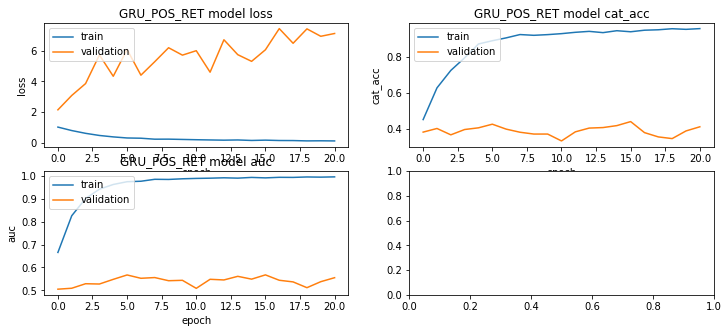

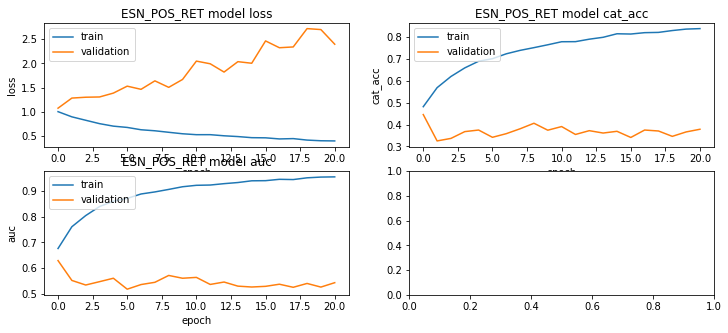

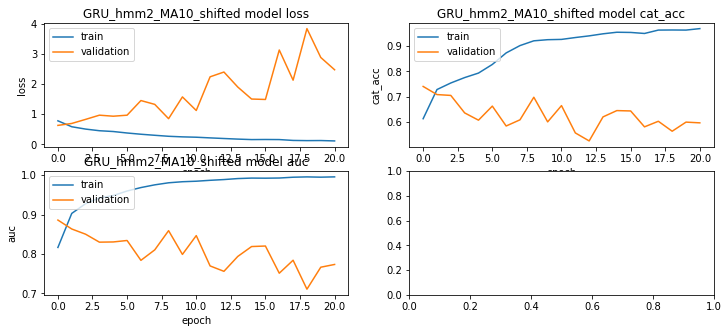

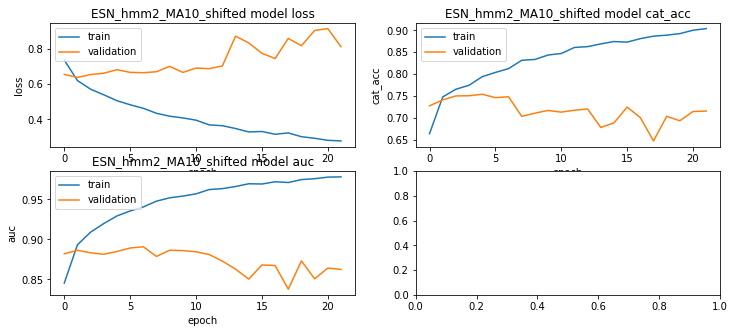

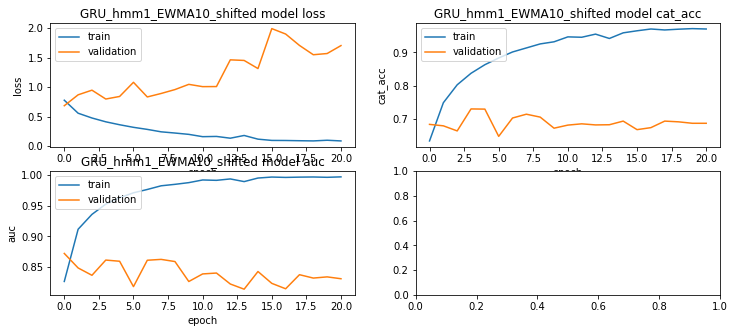

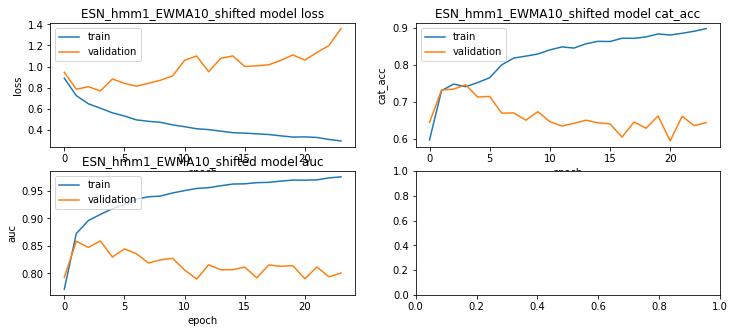

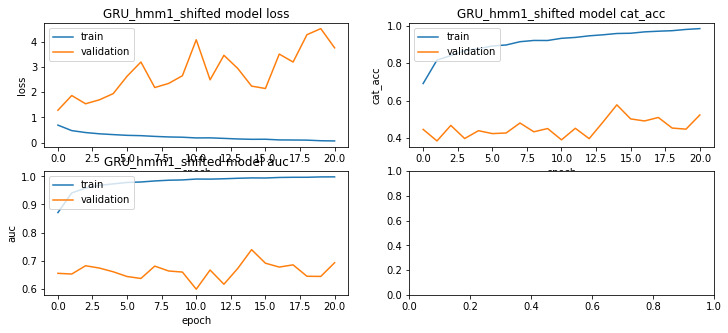

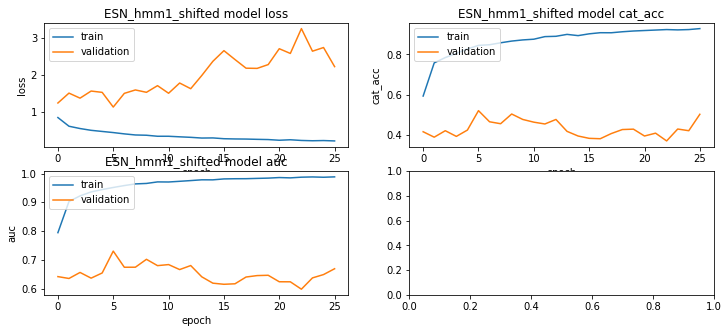

In [ ]:
result = pd.DataFrame(columns=columns)
for i in range(len(labelList)):
  Target = labelList[i]
  targetLabel = targetLabel_List[i]
  DL_obj = DeepLearning( df, numFeat , catFeat, Target, targetLabel, allHMM=allHMM, look_back=look_back)

  for modelName in ['GRU','ESN']:
    # print('Running: '+modelName+'_'+Target)
    DL_obj.train_Model(modelName)
    for d in range(3):
      if d ==0:
        y_pred = DL_obj.y_train_pred
        date = DL_obj.train_date
        Set = 'train'
        score = DL_obj.train_score
      elif d ==1:
        y_pred = DL_obj.y_val_pred
        date = DL_obj.val_date
        Set = 'val'
        score = DL_obj.val_score
      elif d ==2:
        y_pred = DL_obj.y_test_pred
        date = DL_obj.test_date
        Set = 'test'
        score = DL_obj.test_score

      pred_dir = os.path.join(BT_DIR,modelName+'_'+Target+'.csv')
      pd.DataFrame(y_pred).to_csv(pred_dir)
      data = DL_obj.ds.loc[date,['PX_LAST',Target]]
      for threshold in [0,0.4,0.5,0.6,0.7,0.8,0.9,0.95]:
        if threshold==0:
          pred = y_pred.argmax(axis=1)-1
        else:
          pred = pred_threshold(y_pred, threshold)
        pred_name = Target+'_T'+str(threshold)
        data[pred_name] = pred

        _,stat,_ = backtesting_df(data, 'PX_LAST', pred_name,commission=0, plotGraph= False)
        bt_ret = stat['Return [%]']
        bt_Sharpe = stat['Sharpe Ratio']
        bt_Duration = stat['Duration'] 
        bt_ExpTime =  stat['Exposure Time [%]']

        cat_acc = balanced_accuracy_score( data[Target], pred)
        val_input = [Target,modelName,Set,score[0], cat_acc, score[2],threshold,bt_ret,bt_Sharpe,bt_Duration,bt_ExpTime]
        row_input = { columns[z]:val_input[z]  for z in range(len(columns))}
        result_temp = pd.Series(row_input)

        result = result.append(result_temp, ignore_index=True)
        # result = pd.concat([result,result_temp])
        print(result)
      result.to_csv(output_dir)
# columns = ['Label','Model','Set','Loss','Cat_Acc','AUC','Threshold','Return','Sharpe_Ratio']


# Backtesting Graph of our final model

In [ ]:
result_file = os.path.join(BT_DIR,'GRU_hmm2_MA10_shifted.csv')
result = pd.read_csv(result_file,index_col=0)

In [ ]:
date_file = os.path.join(LABEL_DIR,'test_date.csv')
date = pd.read_csv(date_file,index_col=0, parse_dates=True)
date 

,Date
0,2018-01-02
1,2018-01-03
2,2018-01-04
3,2018-01-05
4,2018-01-08
...,...
1018,2022-01-18
1019,2022-01-19
1020,2022-01-20
1021,2022-01-21


In [ ]:
result[['0','1','2']].values

array([[0.08340529, 0.00216066, 0.914434  ],
       [0.08101821, 0.00200728, 0.9169745 ],
       [0.08187397, 0.00206158, 0.91606444],
       ...,
       [0.34930584, 0.3375841 , 0.31311008],
       [0.33183098, 0.4813969 , 0.1867721 ],
       [0.33506796, 0.4545448 , 0.2103873 ]])

In [ ]:
result.index = pd.to_datetime( date.Date)
result['State'] = pred_threshold(result[['0','1','2']].values,0.8)
result

,0,1,2,State
Date,,,,
2018-01-02,0.083405,0.002161,0.914434,1
2018-01-03,0.081018,0.002007,0.916975,1
2018-01-04,0.081874,0.002062,0.916064,1
2018-01-05,0.077099,0.001758,0.921143,1
2018-01-08,0.079326,0.001893,0.918780,1
...,...,...,...,...
2022-01-18,0.248716,0.059091,0.692193,0
2022-01-19,0.307737,0.136335,0.555927,0
2022-01-20,0.349306,0.337584,0.313110,0


In [ ]:
df_BT = df[['PX_LAST']].merge(result[['State']], how='right', left_index=True,right_index=True)

In [ ]:
df_BT.describe()

,PX_LAST,State
count,1023.000000,1023.000000
mean,10492.713773,0.719453
std,2321.136035,0.449486
min,6926.590000,0.000000
25%,8676.720000,0.000000
50%,9414.050000,1.000000
75%,12481.605000,1.000000
max,15484.000000,1.000000


In [ ]:
backtesting_df(df_BT,'PX_LAST', 'State', commission=0)

              Close  State     Open     High      Low
Date                                                 
2018-01-02  8228.76      1  8228.76  8228.76  8228.76
2018-01-03  8276.86      1  8276.86  8276.86  8276.86
2018-01-04  8308.38      1  8308.38  8308.38  8308.38
2018-01-05  8361.79      1  8361.79  8361.79  8361.79
2018-01-08  8377.28      1  8377.28  8377.28  8377.28


(<backtesting.backtesting.Backtest at 0x7f167540fd10>,
 Start                     2018-01-02 00:00:00
 End                       2022-01-24 00:00:00
 Duration                   1483 days 00:00:00
 Exposure Time [%]                   72.531769
 Equity Final [$]                   1428423.58
 Equity Peak [$]                    1532239.71
 Return [%]                          42.842358
 Buy & Hold Return [%]               72.240654
 Return (Ann.) [%]                    9.180881
 Volatility (Ann.) [%]               11.421025
 Sharpe Ratio                         0.803858
 Sortino Ratio                        1.193299
 Calmar Ratio                         1.128418
 Max. Drawdown [%]                   -8.136061
 Avg. Drawdown [%]                   -1.698152
 Max. Drawdown Duration      158 days 00:00:00
 Avg. Drawdown Duration       23 days 00:00:00
 # Trades                                   28
 Win Rate [%]                        64.285714
 Best Trade [%]                       9.157995
 Wors

Start                     2018-01-02 00:00:00
End                       2022-01-24 00:00:00
Duration                   1483 days 00:00:00
Exposure Time [%]                   72.531769
Equity Final [$]                   1428423.58
Equity Peak [$]                    1532239.71
Return [%]                          42.842358
Buy & Hold Return [%]               72.240654
Return (Ann.) [%]                    9.180881
Volatility (Ann.) [%]               11.421025
Sharpe Ratio                         0.803858
Sortino Ratio                        1.193299
Calmar Ratio                         1.128418
Max. Drawdown [%]                   -8.136061
Avg. Drawdown [%]                   -1.698152
Max. Drawdown Duration      158 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades                                   28
Win Rate [%]                        64.285714
Best Trade [%]                       9.157995
Worst Trade [%]                      -3.12035
Avg. Trade [%]                    

In [ ]:
  def createModel_GRU(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100, learning_rate = 0.001):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)

    model.add(Dropout(0.1))
    model.add(GRU(64,activation='tanh', return_sequences	=True))
    model.add(GRU(32,activation='tanh', return_sequences	=True))
    model.add(GRU(16,activation='tanh', return_sequences	=False))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 128 , activation = 'relu', name='Dense0'))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    return model
